This is a simple project I did to better understand my crossfit workouts and behaviors this past year. I scraped workout data from my gym's website and combined that with my attendance, which I tracked using an IFTTT recipe. My goals were to look for any patterns in the crossfit workouts at my gym and see if there were any features that might be informative if I wanted to build a model to predict my future attendance. 

## Preamble

In [1]:
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
from bs4 import BeautifulSoup
import re
%matplotlib inline
pd.set_option('display.notebook_repr_html', True)

## Import and clean data

I first scraped the daily workouts from my gym's website using scrapy and saved it into a JSON lines file. I then transformed this data into dictionaries and lists for later use. I also wanted to look at which muscles these movements used, so I did some quick google searches to classify each movement and created a dictionary with the movements as keys and the muscles used as values. I used this to replace movement terms with muscles used. 

In [2]:
#workout terms
keepwords = np.load('workoutterms.npy').tolist()
#dictionary of movements involving more than one word
mvmt_dict = np.load('mvmt_dict.npy').item()
#muscle groups used during movements
muscle_dict = np.load('muscle_dict.npy').item()

In [3]:
#import raw json lines file
lines = []
with open('wods.jl', 'r') as f:
    for line in f:
        lines.append(json.loads(line))
        
#clean and create dict
wod_dict = dict()
mus_dict = dict()
wods = []
mus =[]
wod_list =[]
mus_list=[]
dates = []
for l in lines:
    if l['all'][0:21]=='<div class="post-meta':
        pass  
    else:
        soup = BeautifulSoup(l['all'],"lxml")
        text = soup.get_text()
        #finds date in post
        d = re.search('(((([13578])|(1[02]))[/](([1-9])|([0][1-9])|([1-2][0-9])|(3[01])))|((([469])|(11))[/](([1-9])|([0][1-9])|([1-2][0-9])|(30)))|((2)[/](([1-9])|([0][1-9])|([1-2][0-9]))))[/](([1][6-7])|(20[1][6-7]))', text)
        try:
            try:
                temp = text.split("Comments",1)[1].lower()
            except IndexError:
                temp = text.split("Comment",1)[1].lower()
            #remove irrelevant characters and trailing s's
            temp = re.sub(r'[^a-zA-Z2]',' ',temp)
            temp = re.sub(r'ohs','overheadsquat',temp)
            temp = re.sub(r'(s\b|[^a-zA-Z2 -])','',temp)
            temp = re.sub(r'  +', ' ',temp)
            #remove spaces from compound terms and classify alternate wordings together
            for i in mvmt_dict.keys():
                temp = temp.replace(i, mvmt_dict[i])
            #split on spaces
            temp = temp.split()
            #save only relevant terms
            temp = [w for w in temp if w in keepwords]
            #remove duplicates
            temp= list(set(temp))
            temp = " ".join(temp)
            
            #add to dictionary of wods
            wod_dict[d.group(0)]=temp
            #add to list of wods (terms only)
            wods.append(temp) 
            dates.append(d.group(0))
            #create list with tuples of (date,terms)
            wod_list.append((d.group(0),temp))
            
            #replace movements with muscles used
            temp = re.sub(r'\brow', ' row', temp)
            temp = re.sub(r'\brun', ' run', temp)
            for i in muscle_dict.keys():
                temp = temp.replace(i, muscle_dict[i])
            #remove duplicates
            temp = " ".join(list(set(temp.split())))
            
            #add to dictionary of muscles
            mus_dict[d.group(0)]=temp
            #add to list of muscles (terms only)
            mus.append(temp)  
            #create list with tuples of (date,muscles)
            mus_list.append((d.group(0),temp))
            
        except AttributeError:
            print text





## Visualizing workout frequencies

I used CountVectorizer to transform each daily workout into a feature vector and used these to look at workout frequencies over the past year.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             ngram_range=(1,1),
                             min_df = 1) 
wod_data_features = vectorizer.fit_transform(wods)
wod_data_features = wod_data_features.toarray()
wod_vocab = vectorizer.get_feature_names()
freq_vec = zip(wod_vocab,
            np.asarray(wod_data_features.sum(axis=0)).ravel(),np.asarray(wod_data_features.mean(axis=0)).ravel())
workout_df = pd.DataFrame.from_records(freq_vec,columns=['movement','freq','prob'])
workout_df = workout_df.sort_values(by='freq',ascending=False)



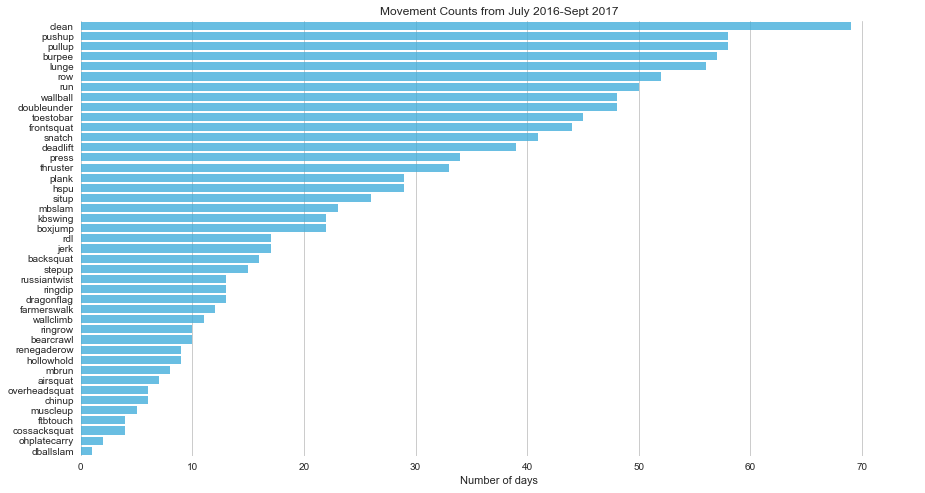

In [5]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(x=workout_df.freq, y=workout_df.movement,color='#43aedb',saturation=1,alpha=.8)
ax.set(xlim=(0,75),ylabel="",
       xlabel="Number of days",
      title='Movement Counts from July 2016-Sept 2017')
plt.setp(ax.patches, linewidth=0)
sns.despine(left=True, bottom=True)

This data matches my experience for the most part--I knew that we performed certain movements more often than others. But there were a few things that surpised me. For instance, we work on front squats about 3x more often than we work on back squats, and rowing and running occurred at about the same frequency despite running being a seasonal workout since it must be performed outdoors. I wondered how this plot would look if I grouped these movements according to which muscles they used. 

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             ngram_range=(1,1),
                             min_df = 1) 
mus_data_features = vectorizer.fit_transform(mus)
mus_data_features = mus_data_features.toarray()
mus_vocab = vectorizer.get_feature_names()
freq_vec = zip(mus_vocab,
            np.asarray(mus_data_features.sum(axis=0)).ravel())
m_df = pd.DataFrame.from_records(freq_vec,columns=['muscle','freq'])
m_df = m_df.sort_values(by='freq',ascending=False)

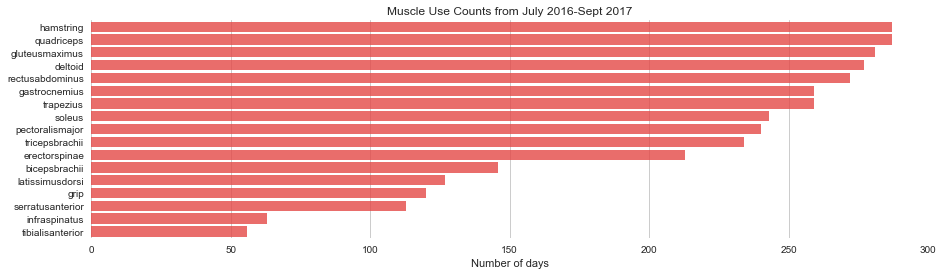

In [7]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 4))

sns.barplot(x=m_df.freq, y=m_df.muscle, color='#E44846',saturation=1,alpha=.8)
ax.set(xlim=(0,300),ylabel="",
       xlabel="Number of days",
      title='Muscle Use Counts from July 2016-Sept 2017')
plt.setp(ax.patches, linewidth=0)
sns.despine(left=True, bottom=True)

This plot aligns with my experience, too. These top three muscles are always sore! It does seem that Crossfit engages many of the main muscle types fairly equally, although if I wanted to improve my lats, biceps, and grip muscles then it would probably help to work on these on my own. 

I also wanted to see in general how balanced our workouts were over the course of the year and whether or not there were any patterns in the programming.

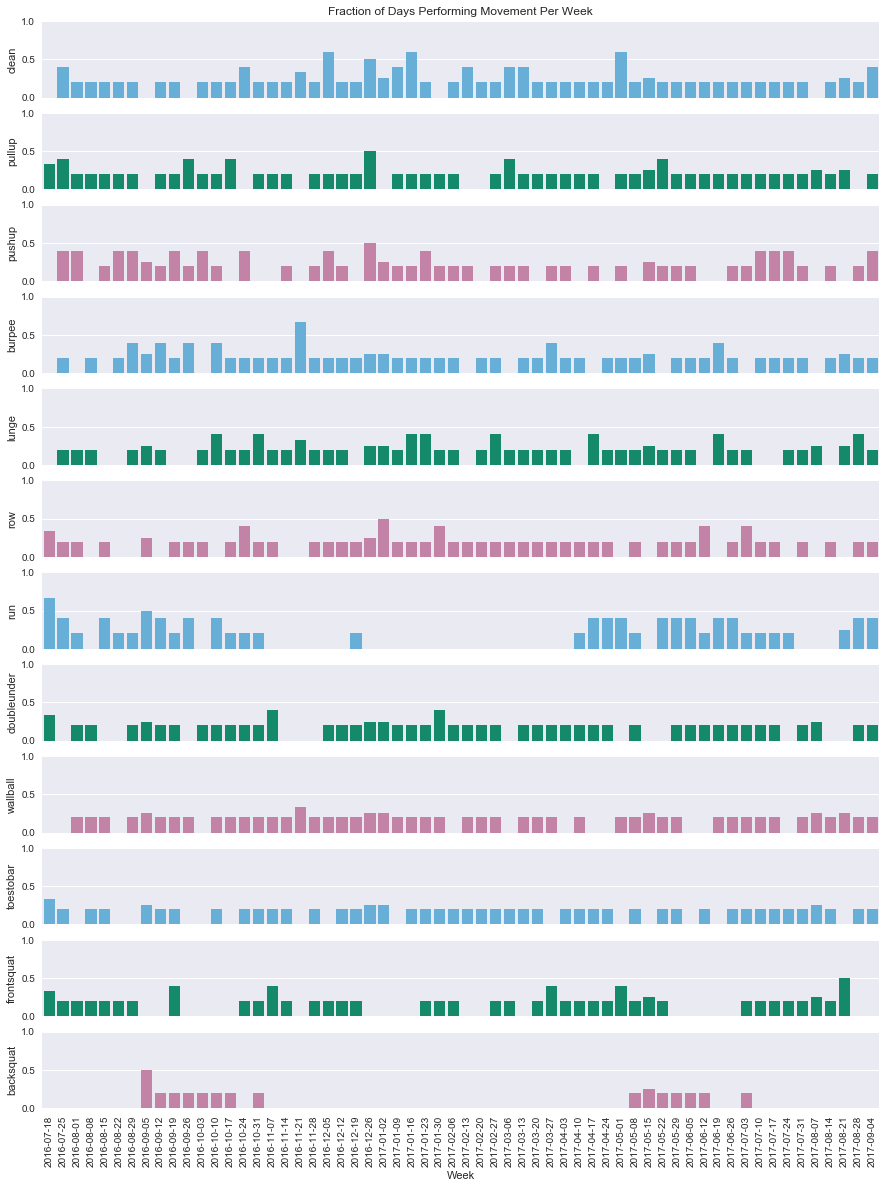

In [8]:
#function to count fraction per week
def makecountcol(col_name,feature_array,df,vocab,binary=True):
    voc_count = []
    for v in feature_array:
        voc_count.append(v[vocab.index(col_name)])
    voc_count = pd.Series(voc_count)
    if binary:
        df[col_name] = [int(x>0) for x in voc_count.values]
    else:
        df[col_name] = voc_count.values
    return

#workouts into dataframe, group days by week 
labels = ['date','text']
wod_df = pd.DataFrame.from_records(wod_list, columns=labels)
wod_df['date'] =pd.to_datetime(wod_df.date)
wod_df['date']= wod_df['date'].dt.to_period('W')

plot_choices = [u'clean', u'pullup', u'pushup',u'burpee',
                u'lunge',u'row',u'run',u'doubleunder',u'wallball',
                u'toestobar',u'frontsquat',u'backsquat']

#make a column of fraction of days per week 
for w in range(len(plot_choices)):
    try:
        makecountcol(plot_choices[w],wod_data_features,wod_df,wod_vocab,True)
        if w == 0:
            byweek_df = wod_df[plot_choices[w]].groupby(wod_df.date).mean().to_frame()   
        else:
            byweek_df[plot_choices[w]] = wod_df[plot_choices[w]].groupby(wod_df.date).mean()
    except ValueError:
        print plot_choices[w]
byweek_df.index = byweek_df.index.to_timestamp()
byweek_df.reset_index(inplace=True)

#plot
sns.set()
fig1 = plt.figure(figsize=(15,20))
colors = ["#56B4E9",  "#009E73","#CC79A7"]
for w in range(len(plot_choices)):
    
    if w == 0:
        ax = plt.subplot(len(plot_choices),1,w+1)
        g_f = sns.barplot(x=byweek_df.date.dt.date, y=byweek_df[plot_choices[w]], data=byweek_df,color=colors[w%3])
        plt.setp(ax.patches, linewidth=0)
        g_f.set(xticklabels=[],xlabel='')
        plt.title('Fraction of Days Performing Movement Per Week')
        
    elif w == len(plot_choices)-1:
        ax_l = plt.subplot(len(plot_choices),1,w+1)
        g_l=sns.barplot(x=byweek_df.date.dt.date, y=byweek_df[plot_choices[w]], data=byweek_df,color=colors[w%3])
        plt.setp(ax_l.patches, linewidth=0)
        ax_l.set(xlabel='Week')
        plt.xticks(rotation=90)

    else:
        ax_m = plt.subplot(len(plot_choices),1,w+1)
        g=sns.barplot(x=byweek_df.date.dt.date, y=byweek_df[plot_choices[w]], data=byweek_df,color=colors[w%3])
        plt.setp(ax_m.patches, linewidth=0)
        ax_m.set(xticklabels=[],xlabel='')
        
    plt.ylabel(plot_choices[w])
    plt.ylim((0,1))
    sns.despine(left=True, bottom=True)
    

Above I've plotted the fraction of days per week that we performed various movements (out of the posted workout days, so this doesn't include holidays and weekends or days when the blog had no entry). The movements we do most often, like the clean and pull-up, are pretty evenly spread throughout the year. The exception to this is running, which, as I mentioned before, is something we don't do in the winter. Accordingly, there is a gap in the frequency plot for running (although there must have been a nice day in December 2016!). Movements are usually only performed once or twice per week. The back squat pattern seen in the last row reflects the fact that we did two several-week-long series working on this movement, but it seems that we don't work on it very often aside from that.

So how does this same information look if we plot the workouts in terms of muscle groups used?

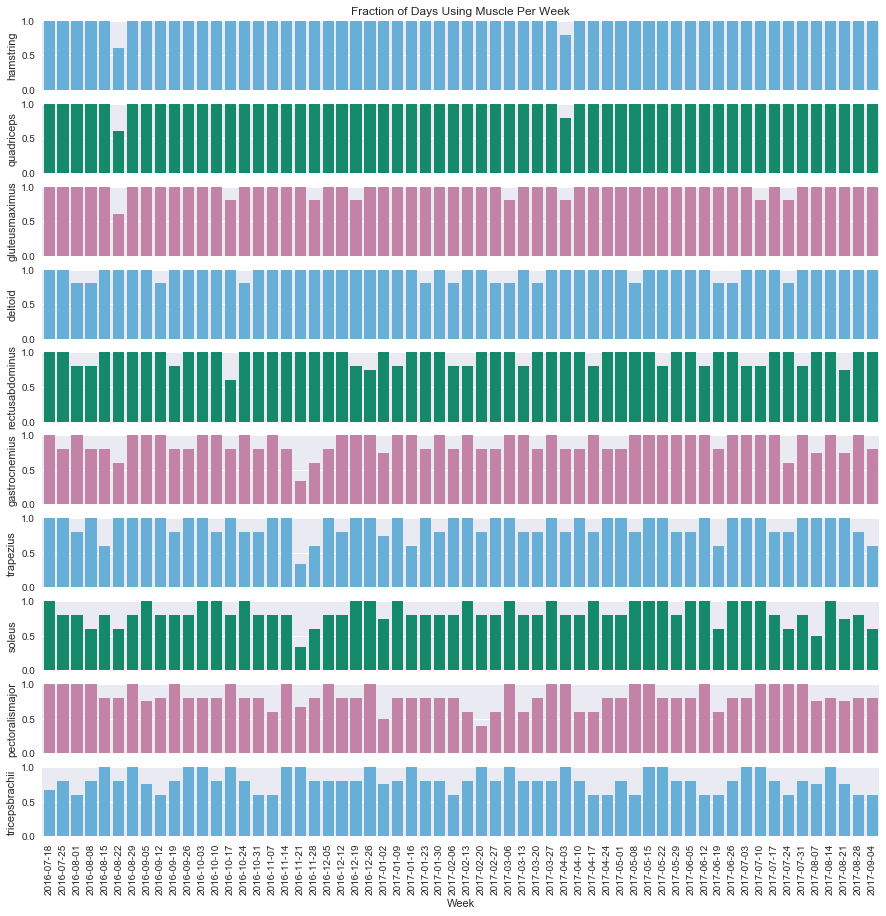

In [9]:
#workouts into dataframe, group days by week 
labels = ['date','text']
mus_df = pd.DataFrame.from_records(mus_list, columns=labels)
mus_df['date'] =pd.to_datetime(mus_df.date)
mus_df['date']= mus_df['date'].dt.to_period('W')

plot_choices = list(m_df.muscle[0:10])

#make a column of fraction of days per week 
for w in range(len(plot_choices)):
    try:
        makecountcol(plot_choices[w],mus_data_features,mus_df,mus_vocab,True)
        if w == 0:
            byweek_df = mus_df[plot_choices[w]].groupby(mus_df.date).mean().to_frame()   
        else:
            byweek_df[plot_choices[w]] = mus_df[plot_choices[w]].groupby(mus_df.date).mean()
    except ValueError:
        print plot_choices[w]
byweek_df.index = byweek_df.index.to_timestamp()
byweek_df.reset_index(inplace=True)

#plot
sns.set()
fig1 = plt.figure(figsize=(15,15))
colors = ["#56B4E9",  "#009E73","#CC79A7"]
for w in range(len(plot_choices)):
    
    if w == 0:
        ax = plt.subplot(len(plot_choices),1,w+1)
        g_f = sns.barplot(x=byweek_df.date.dt.date, y=byweek_df[plot_choices[w]], data=byweek_df,color=colors[w%3])
        plt.setp(ax.patches, linewidth=0)
        g_f.set(xticklabels=[],xlabel='')
        plt.title('Fraction of Days Using Muscle Per Week')
        
    elif w == len(plot_choices)-1:
        ax_l = plt.subplot(len(plot_choices),1,w+1)
        g_l=sns.barplot(x=byweek_df.date.dt.date, y=byweek_df[plot_choices[w]], data=byweek_df,color=colors[w%3])
        plt.setp(ax_l.patches, linewidth=0)
        ax_l.set(xlabel='Week')
        plt.xticks(rotation=90)

    else:
        ax_m = plt.subplot(len(plot_choices),1,w+1)
        g=sns.barplot(x=byweek_df.date.dt.date, y=byweek_df[plot_choices[w]], data=byweek_df,color=colors[w%3])
        plt.setp(ax_m.patches, linewidth=0)
        ax_m.set(xticklabels=[],xlabel='')
        
    plt.ylabel(plot_choices[w])
    plt.ylim((0,1))
    sns.despine(left=True, bottom=True)
    

So most days we're using a lot of different muscles, and we use some muscles almost every day. 

Are there movements that tend to co-occur? Let's look at a co-occurance matrix. I will remove movements that we did fewer than 10 times since there isn't enough data to interpret the co-occurance of these terms.

[Text(0,0,u'backsquat'),
 Text(0,0,u'bearcrawl'),
 Text(0,0,u'boxjump'),
 Text(0,0,u'burpee'),
 Text(0,0,u'clean'),
 Text(0,0,u'deadlift'),
 Text(0,0,u'doubleunder'),
 Text(0,0,u'dragonflag'),
 Text(0,0,u'farmerswalk'),
 Text(0,0,u'frontsquat'),
 Text(0,0,u'hspu'),
 Text(0,0,u'jerk'),
 Text(0,0,u'kbswing'),
 Text(0,0,u'lunge'),
 Text(0,0,u'mbslam'),
 Text(0,0,u'plank'),
 Text(0,0,u'press'),
 Text(0,0,u'pullup'),
 Text(0,0,u'pushup'),
 Text(0,0,u'rdl'),
 Text(0,0,u'ringdip'),
 Text(0,0,u'ringrow'),
 Text(0,0,u'row'),
 Text(0,0,u'run'),
 Text(0,0,u'russiantwist'),
 Text(0,0,u'situp'),
 Text(0,0,u'snatch'),
 Text(0,0,u'stepup'),
 Text(0,0,u'thruster'),
 Text(0,0,u'toestobar'),
 Text(0,0,u'wallball'),
 Text(0,0,u'wallclimb')]

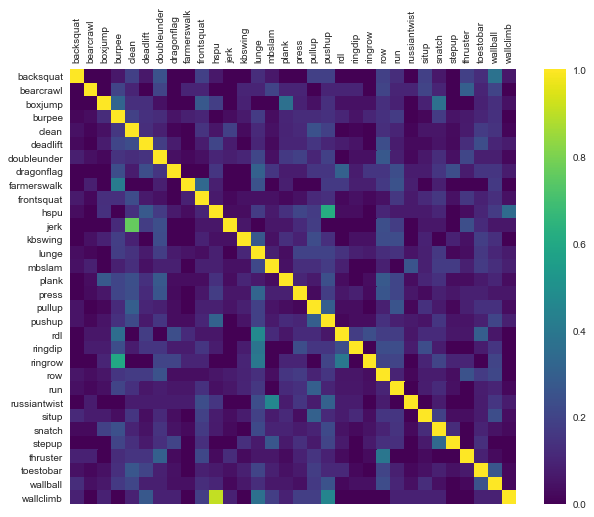

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             ngram_range=(1,1),
                             min_df = 10) 
wod_data_features = vectorizer.fit_transform(wods)
wod_vocab = vectorizer.get_feature_names()

com = (wod_data_features.T * wod_data_features)
com = com.toarray()
com_diag = np.diagonal(com)
with np.errstate(divide='ignore', invalid='ignore'):
        com_perc = np.nan_to_num(np.true_divide(com, com_diag[:,None]))


fig, ax = plt.subplots(figsize=(10, 8))   

c=ax.pcolor(com_perc,cmap='viridis')
plt.colorbar(c)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.set_xticks(np.arange(com.shape[1]) + 0.5, minor=False)
ax.set_xticklabels(wod_vocab, minor=False,rotation='vertical')
ax.set_yticks(np.arange(com.shape[0]) + 0.5, minor=False)
ax.set_yticklabels(wod_vocab, minor=False)


There aren't that many terms that co-occur frequently. Let's look at the terms that occur together 75% of the time or more.

In [11]:
(mvmt_1, mvmt_2)=(np.where(np.logical_and(com_perc>=.75,com_perc<1.0)))
co_mvmts = zip([wod_vocab[i] for i in mvmt_1.tolist()],[wod_vocab[j] for j in mvmt_2.tolist()])
for i in co_mvmts:
    print '%s tends to occur with %s' % i

jerk tends to occur with clean
wallclimb tends to occur with hspu


A clean and jerk is a composite weightlifting movement that we do, and wall climbs are a scaled version of handstand push-ups, so both of these would tend to happen on the same day.

## My visits

I've talked a lot about the workouts that happen at my gym, but I've kept a secret from you: I don't go every day. I wanted to find out if there were any interesting patterns in my own visits. Am I avoiding certain types of workouts? Do I tend to go on certain days of the week? Did I go more or less frequently when I was writing my thesis? I collected data on my gym visits for the past year using an IFTTT recipe and transformed this data into a list of dates. It's not completely accurate because there are some times when my phone wasn't working properly, or I had the app turned off, but I should still be able to get some insights. 

In [12]:
attend=pd.read_csv('attendance.csv')
attend.date=pd.to_datetime(attend.date)

Here is the probability of me attending given that a particular movement was scheduled.

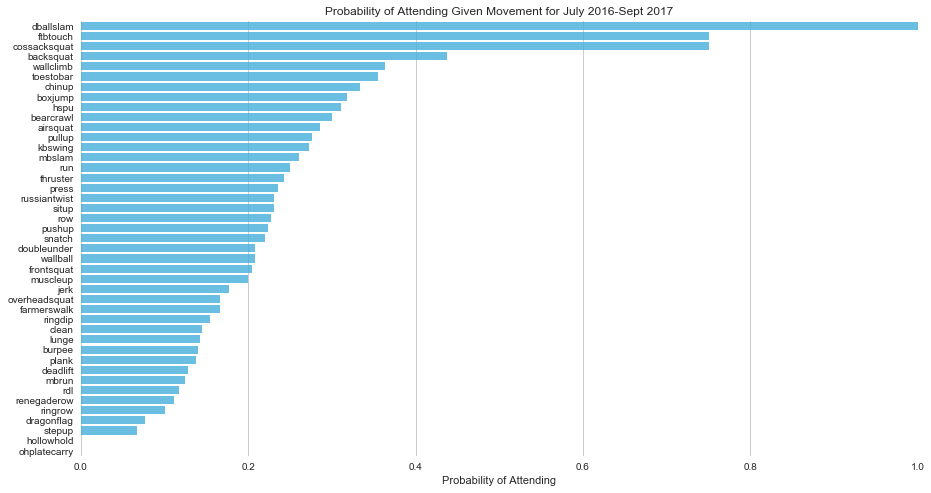

In [13]:
#perform right outer join on workout dataframe and attendance dataframe
labels = ['date','text']
wod_df = pd.DataFrame.from_records(wod_list, columns=labels)
wod_df['date'] =pd.to_datetime(wod_df.date)
comb_df=attend.merge(wod_df,on='date',how='right')
comb_df.loc[comb_df.attend.isnull(),'attend']=0.0
workout_names = list(workout_df.movement)
workout_probs = workout_df.prob

p_attend = comb_df.attend.mean()

p_attend_given_wkt=[]
for w in workout_names:
    for i in comb_df.itertuples():
        if w in i.text:
            comb_df.loc[i.Index,w] = int((i.attend == 1))
    p_attend_given_wkt.append((w,comb_df[w].mean()))

prob_df_1 = pd.DataFrame.from_records(p_attend_given_wkt,columns=['movement','prob_agm'])
prob_df_1 =prob_df_1.sort_values(by='prob_agm',ascending=False)

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 8))

sns.barplot(x=prob_df_1.prob_agm, y=prob_df_1.movement,color='#43aedb',saturation=1,alpha=.8)
ax.set(xlim=(0,1),ylabel="",
       xlabel="Probability of Attending",
      title='Probability of Attending Given Movement for July 2016-Sept 2017')
plt.setp(ax.patches, linewidth=0)
sns.despine(left=True, bottom=True)

Although at first glance this might seem like I'm selecting days to attend based on the workout, this obviously isn't the whole picture (e.g. dball slams only happened once during this period, and I happened to attend). What I'd like to know is if the event "attend" (A) and the event "movement" (M) are independent of each other. In other words, if my attendance and the movements are independent, then 

$P(A \cap M) = P(A)P(M)$

which can also be expressed as

$P(M) = P(M|A)$

So let's compare the probabily of movements on the days that I attended to the overall probability of movements. 

[Text(0,0,u'0.4'),
 Text(0,0,u'0.3'),
 Text(0,0,u'0.2'),
 Text(0,0,u'0.1'),
 Text(0,0,u'0'),
 Text(0,0,u'0.1'),
 Text(0,0,u'0.2'),
 Text(0,0,u'0.3')]

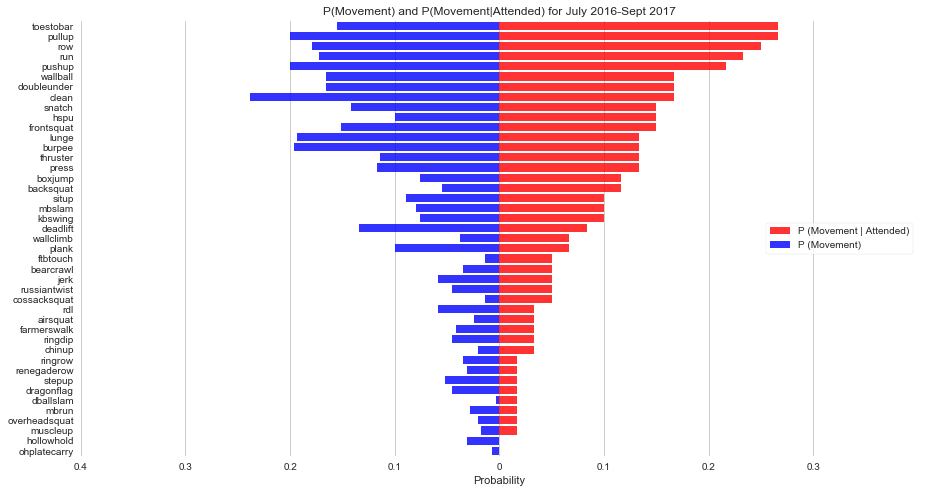

In [14]:
#remove long periods in which tracking didn't work
#comb_df = comb_df[(comb_df.date.dt.date <= datetime.date(2016,11,2))| (comb_df.date.dt.date >= datetime.date(2017,2,26))]
#comb_df = comb_df[(comb_df.date.dt.date <= datetime.date(2017,3,6))| (comb_df.date.dt.date >= datetime.date(2017,5,11))]
p_wkt_given_attend=[]

for index, row in comb_df.iterrows():
    if row['attend'] == 1:
        for w in workout_names:
            comb_df.loc[index,w + '_c'] =  int((w in row['text']))
            
p_wkt_given_attend = []    
f_wkt_given_attend = []  
for i,w in enumerate(workout_names):
    p_wkt_given_attend.append((w,comb_df[w + '_c'].mean()))
    f_wkt_given_attend.append((w,comb_df[w+'_c'].sum()))

prob_df_2 = pd.DataFrame.from_records(p_wkt_given_attend,columns=['movement','prob_mga'])
freq_df_2 = pd.DataFrame.from_records(f_wkt_given_attend,columns=['movement','f_mga'])
prob_df=prob_df_1.merge(prob_df_2,how='inner',on='movement').merge(workout_df,how='inner',on='movement')
prob_df = prob_df.sort_values(by='prob_mga',ascending=False)

sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 8))

g=sns.barplot(x=prob_df.prob_mga, y=prob_df.movement,color='red',saturation=1,alpha=.8,label='P (Movement | Attended)')
j=sns.barplot(x=-prob_df.prob, y=prob_df.movement,color='blue',saturation=1,alpha=.8,label='P (Movement)')
ax.set(xlim=(-.4,.4),ylabel="",
       xlabel="Probability",
      title='P(Movement) and P(Movement|Attended) for July 2016-Sept 2017')
plt.setp(ax.patches, linewidth=0)
sns.despine(left=True, bottom=True)
ax.legend(ncol=1, loc="center right", frameon=True)
j.set_xticks(np.arange(-.4,.4,.1))
j.set_xticklabels([.4,.3,.2,.1,0,.1,.2,.3,.4])

These seem to roughly match. There might be some slight differences, but are these differences meaningful? I considered performing a $\chi^{2}$ test to test for statistical independence, but the movement categories aren't mutually exclusive. I could make my categories mutually exclusive with a little effort, but, instead, I just performed a bootstrap analysis to see the probabiliy that these differences could be observed by chance assuming no true difference.

In [15]:
#bootstrap?

boot_df=wod_df
for index, row in boot_df.iterrows():
    for w in workout_names:
        boot_df.loc[index,w] =  int((w in row['text']))
result_df = pd.DataFrame()
num_samples = 10000
for i in range(0,num_samples):
    #sample n days with replacement, n = number of days attended 
    temp_df=boot_df.sample(n=len(attend),replace=True)
    for w in workout_names:
        result_df.loc[i,w]=temp_df[w].mean()


In [16]:
try:
    prob_df=prob_df.set_index('movement')
except KeyError:
    pass
p_values = []
for w in workout_names:
    temp = result_df[w].sort_values().reset_index(drop=True)
    #number of samples with probabilities >= or <= observed probabilities
    temp_u= len(temp[temp >= prob_df.loc[w,'prob_mga']])/float(num_samples)
    temp_l= len(temp[temp <= prob_df.loc[w,'prob_mga']])/float(num_samples)
    p_values.append(min(temp_l,temp_u))
    if 2*min(temp_l,temp_u) < .05:
        print (2*min(temp_l,temp_u),w)


(0.0106, u'toestobar')
(0.0352, u'backsquat')
(0.0382, u'ftbtouch')
(0.0322, u'cossacksquat')


Above are computed p-values that are < .05, but since we're making multiple comparisons, we should use the Bonferonni correction to control the familywise error rate. To do this, we just divide our alpha (.05) by the number of hypothesses (number of workout names in this case). 

In [17]:
try:
    prob_df=prob_df.set_index('movement')
except KeyError:
    pass
p_values = []
for w in workout_names:
    temp = result_df[w].sort_values().reset_index(drop=True)
    #number of samples with probabilities >= or <= observed probabilities
    temp_u= len(temp[temp >= prob_df.loc[w,'prob_mga']])/float(num_samples)
    temp_l= len(temp[temp <= prob_df.loc[w,'prob_mga']])/float(num_samples)
    p_values.append(min(temp_l,temp_u))
    if 2*min(temp_l,temp_u) < .05/len(workout_names):
        # bonferroni, .05/len(workout_names) #cannot assume independence
        print (2*min(emp_l,temp_u),w)

None of the p-values are signficant now! The Bonferonni correction is conservative and good when it's costly to have a false positive, but for my purposes a few false positives aren't a big deal, so I decided to use the Benjamini-Hochberg test. This works by controlling the false discovery rate. I'll set my false discovery rate, q, to be 10%.

Text(0,0.5,u'p(i)')

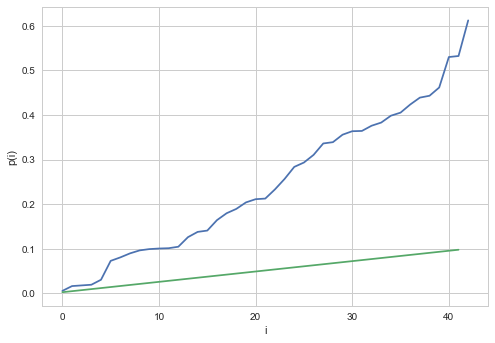

In [18]:

#Benjamini–Hochberg, test if p-values follow a uniform distr.    
p_values.sort()
plt.plot(p_values)
q = .10
plt.plot(np.arange(1,len(p_values))*q/len(workout_names))
plt.xlabel('i')
plt.ylabel('p(i)')


So we're looking for the largest p-value that's less than q*i/N, where N is the total number of hypotheses. These would be p-values, in blue, that are below the green line, and there are none. So I can't rule out that my attendance had nothing to do with the movements for that day. Maybe with more data I would find some subtle patterns. 

I'm guessing that my attendance is more likely to reflect aspects of my life that are difficult to model (e.g. stress at work, soreness from previous workouts, etc.), but I'll just see if I tend to go on certain days of the week.

Text(0,0.5,u'Count')

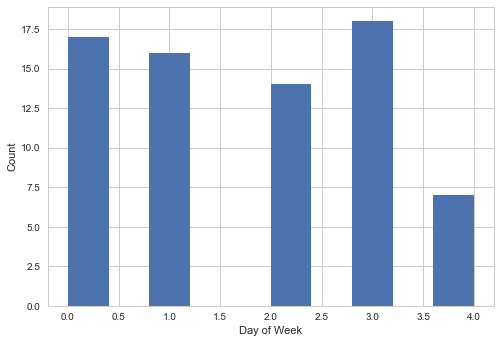

In [19]:
attend.date.dt.weekday.hist()
plt.xlabel('Day of Week')
plt.ylabel('Count')

It's not surprising to me that I don't go very often on Fridays. I find it difficult to get to the class time offered. I notice a slight dip on Tuesday and especially Wednesday. My guess is that I'm sometimes sore from Monday or Tuesday's workout, so I don't attend on Wednesday. By Thursday I'm back to normal and probably trying to fit in another workout before the end of the week. I expect that a useful feature to include in my model will be the recent history of my attendance.

## Use a Linear Classifier to Predict Attendance with Various Features

I decided to play around with a few simple linear classifiers to see how well these models did out of the box. Features I'll include:

1. day of week (integer)
2. month (integer)
3. day of month (integer)
4. workout movements (binary)
5. muscles used (binary)
6. history of attandence (binary; 1 day ago, 2 days ago, 3 days ago, 4 days ago)

In [20]:
labels = ['date','text']
wod_df = pd.DataFrame.from_records(wod_list, columns=labels)
wod_df['date'] =pd.to_datetime(wod_df.date)
new_df=attend.merge(wod_df,on='date',how='right')
new_df.loc[new_df.attend.isnull(),'attend']=0.0

#remove long periods in which tracking didn't work
new_df =new_df[(new_df.date.dt.date <= datetime.date(2016,11,2))| (new_df.date.dt.date >= datetime.date(2017,2,26))]
new_df = new_df[(new_df.date.dt.date <= datetime.date(2017,3,6))| (new_df.date.dt.date >= datetime.date(2017,5,11))]


Here I've just included the workout movements, and I'll run them through a Naive Bayes classifier.

In [21]:
#just workout terms
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             ngram_range=(1,1),
                             min_df = 1) 
vectorizer.fit(new_df.text)
      
def tvt_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test


train,valid,test = tvt_split(new_df)

train_data = vectorizer.transform(train.text)
train_labels = train.attend
valid_data = vectorizer.transform(valid.text)
valid_labels = valid.attend
test_data = vectorizer.transform(valid.text)
test_labels = test.attend


In [22]:
import sklearn
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(train_data, train_labels)
print('train')
import sklearn.metrics
print(sklearn.metrics.classification_report(train_labels,clf.predict(train_data)))
print('valid')
print(sklearn.metrics.classification_report(valid_labels,clf.predict(valid_data)))

train
             precision    recall  f1-score   support

        0.0       0.79      0.94      0.86        66
        1.0       0.81      0.52      0.63        33

avg / total       0.80      0.80      0.78        99

valid
             precision    recall  f1-score   support

        0.0       0.59      0.85      0.69        20
        1.0       0.25      0.08      0.12        13

avg / total       0.45      0.55      0.47        33



It does a little better than chance. What happens if I add muscle names?

In [23]:
#adding muscle names
labels = ['date','text']
mus_df = pd.DataFrame.from_records(mus_list, columns=labels)
mus_df['date'] =pd.to_datetime(mus_df.date)
mandw_df=mus_df.merge(new_df,on='date',how='right')

mandw_df.loc[mandw_df.attend.isnull(),'attend']=0.0
mandw_df['features'] = mandw_df.text_x.map(str) + ' ' + mandw_df.text_y


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000,
                             ngram_range=(1,1),
                             min_df = 1) 
vectorizer.fit(mandw_df.features)
      
def tvt_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.ix[perm[:train_end]]
    validate = df.ix[perm[train_end:validate_end]]
    test = df.ix[perm[validate_end:]]
    return train, validate, test


train,valid,test = tvt_split(mandw_df)

train_data = vectorizer.transform(train.features)
train_labels = train.attend
valid_data = vectorizer.transform(valid.features)
valid_labels = valid.attend
test_data = vectorizer.transform(valid.features)
test_labels = test.attend


In [25]:
clf = MultinomialNB()
clf.fit(train_data, train_labels)

import sklearn.metrics
print 'train'
print(sklearn.metrics.classification_report(train_labels,clf.predict(train_data)))
print 'valid'
print(sklearn.metrics.classification_report(valid_labels,clf.predict(valid_data)))


train
             precision    recall  f1-score   support

        0.0       0.79      0.97      0.87        65
        1.0       0.89      0.50      0.64        34

avg / total       0.82      0.81      0.79        99

valid
             precision    recall  f1-score   support

        0.0       0.54      0.72      0.62        18
        1.0       0.44      0.27      0.33        15

avg / total       0.50      0.52      0.49        33



It does about the same.

What if I add date information and information about my recent history of attendance?

In [26]:
# add date information
#test
train_features = vectorizer.transform(train.features).toarray()

weekdays = np.array(train.date.dt.weekday).reshape(np.shape(train_features)[0],1)
feat_vecs = np.hstack((train_features,weekdays))

months = np.array(train.date.dt.month).reshape(np.shape(train_features)[0],1)
feat_vecs = np.hstack((feat_vecs,months))

days = np.array(train.date.dt.day).reshape(np.shape(train_features)[0],1)
feat_vecs = np.hstack((feat_vecs,days))

#date history
attend=pd.read_csv('attendance.csv')
attend.date=pd.to_datetime(attend.date)

train['minus_one'] = train.date - datetime.timedelta(days=1)
for i,r in train.iterrows():
    if attend.date[attend.date == r.minus_one].count():
        train.loc[i,'one'] =1
    else:
        train.loc[i,'one'] =0
train = train.drop('minus_one',axis=1)

train['minus_two'] = train.date - datetime.timedelta(days=2)
for i,r in train.iterrows():
    if attend.date[attend.date == r.minus_two].count():
        train.loc[i,'two'] =1
    else:
        train.loc[i,'two'] =0
train = train.drop('minus_two',axis=1)

train['minus_three'] = train.date - datetime.timedelta(days=3)
for i,r in train.iterrows():
    if attend.date[attend.date == r.minus_three].count():
        train.loc[i,'three'] =1
    else:
        train.loc[i,'three'] =0
train = train.drop('minus_three',axis=1)

train['minus_four'] = train.date - datetime.timedelta(days=4)
for i,r in train.iterrows():
    if attend.date[attend.date == r.minus_four].count():
        train.loc[i,'four'] =1
    else:
        train.loc[i,'four'] =0
train = train.drop('minus_four',axis=1)

m_one = np.array(train.one).reshape(np.shape(train_features)[0],1)
feat_vecs = np.hstack((feat_vecs,m_one))

m_two = np.array(train.two).reshape(np.shape(train_features)[0],1)
feat_vecs = np.hstack((feat_vecs,m_two))

m_three = np.array(train.three).reshape(np.shape(train_features)[0],1)
feat_vecs = np.hstack((feat_vecs,m_three))

m_four = np.array(train.four).reshape(np.shape(train_features)[0],1)
feat_vecs = np.hstack((feat_vecs,m_four))
dates_only_feat_vecs = feat_vecs[:,60:68]


In [27]:
#valid
valid_features = vectorizer.transform(valid.features).toarray()

weekdays = np.array(valid.date.dt.weekday).reshape(np.shape(valid_features)[0],1)
valid_feat_vecs = np.hstack((valid_features,weekdays))

months = np.array(valid.date.dt.month).reshape(np.shape(valid_features)[0],1)
valid_feat_vecs = np.hstack((valid_feat_vecs,months))

days = np.array(valid.date.dt.day).reshape(np.shape(valid_features)[0],1)
valid_feat_vecs = np.hstack((valid_feat_vecs,days))

#date history
attend=pd.read_csv('attendance.csv')
attend.date=pd.to_datetime(attend.date)

valid['minus_one'] = valid.date - datetime.timedelta(days=1)
for i,r in valid.iterrows():
    if attend.date[attend.date == r.minus_one].count():
        valid.loc[i,'one'] =1
    else:
        valid.loc[i,'one'] =0
valid = valid.drop('minus_one',axis=1)

valid['minus_two'] = valid.date - datetime.timedelta(days=2)
for i,r in valid.iterrows():
    if attend.date[attend.date == r.minus_two].count():
        valid.loc[i,'two'] =1
    else:
        valid.loc[i,'two'] =0
valid = valid.drop('minus_two',axis=1)

valid['minus_three'] = valid.date - datetime.timedelta(days=3)
for i,r in valid.iterrows():
    if attend.date[attend.date == r.minus_three].count():
        valid.loc[i,'three'] =1
    else:
        valid.loc[i,'three'] =0
valid = valid.drop('minus_three',axis=1)

valid['minus_four'] = valid.date - datetime.timedelta(days=4)
for i,r in valid.iterrows():
    if attend.date[attend.date == r.minus_four].count():
        valid.loc[i,'four'] =1
    else:
        valid.loc[i,'four'] =0
valid = valid.drop('minus_four',axis=1)

m_one = np.array(valid.one).reshape(np.shape(valid_features)[0],1)
valid_feat_vecs = np.hstack((valid_feat_vecs,m_one))

m_two = np.array(valid.two).reshape(np.shape(valid_features)[0],1)
valid_feat_vecs = np.hstack((valid_feat_vecs,m_two))

m_three = np.array(valid.three).reshape(np.shape(valid_features)[0],1)
valid_feat_vecs = np.hstack((valid_feat_vecs,m_three))

m_four = np.array(valid.four).reshape(np.shape(valid_features)[0],1)
valid_feat_vecs = np.hstack((valid_feat_vecs,m_four))

dates_only_valid_feat_vecs = valid_feat_vecs[:,60:68]

First I'll look at date information only as features.

In [28]:
clf = MultinomialNB()
clf.fit(dates_only_feat_vecs, train_labels)
#print np.shape(dates_only_feat_vecs)
import sklearn.metrics
print 'train'
print(sklearn.metrics.classification_report(train_labels,clf.predict(dates_only_feat_vecs)))

print 'valid'
print(sklearn.metrics.classification_report(valid_labels,clf.predict(dates_only_valid_feat_vecs)))

train
             precision    recall  f1-score   support

        0.0       0.66      0.94      0.78        65
        1.0       0.43      0.09      0.15        34

avg / total       0.58      0.65      0.56        99

valid
             precision    recall  f1-score   support

        0.0       0.53      0.89      0.67        18
        1.0       0.33      0.07      0.11        15

avg / total       0.44      0.52      0.41        33



It seems to do poorly. What if I combine all features?

In [29]:
clf = MultinomialNB()
clf.fit(feat_vecs, train_labels)
#print np.shape(dates_only_feat_vecs)
import sklearn.metrics
print 'train'
print(sklearn.metrics.classification_report(train_labels,clf.predict(feat_vecs)))

print 'valid'
print(sklearn.metrics.classification_report(valid_labels,clf.predict(valid_feat_vecs)))

train
             precision    recall  f1-score   support

        0.0       0.77      0.95      0.85        65
        1.0       0.83      0.44      0.58        34

avg / total       0.79      0.78      0.76        99

valid
             precision    recall  f1-score   support

        0.0       0.57      0.67      0.62        18
        1.0       0.50      0.40      0.44        15

avg / total       0.54      0.55      0.54        33



It does a little better, but this is about equal to the performance using just workout names. This might work better if I use a non-linear classifier or add more features (e.g. weather).